In [360]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np 
from matplotlib import pyplot as plt 

from load_mnist import load_mnist 

In [ ]:
# Loading training and testing data
xtrain, ytrain, xtest, ytest = load_mnist() 

In [361]:
# Get dimensions of training and testing data
M = ytrain.shape[1] 
p = xtrain.shape[1] 

ntrain = xtrain.shape[0] 
ntest = xtest.shape[0] 

In [363]:
# Converting training and testing data to torch tensors 
xtra_torch = torch.tensor(xtrain).float()
ytra_torch = torch.tensor(ytrain).float()
xtes_torch = torch.tensor(xtest).float()
ytes_torch = torch.tensor(ytest).float()

# Converting our flat vectors to images for the CNNs
xtra_conv = torch.tensor(xtrain).reshape(ntrain, 28, 28).float().unsqueeze(1)
ytra_conv = torch.tensor(ytrain).float()
xtes_conv = torch.tensor(xtest).reshape(ntest, 28, 28).float().unsqueeze(1)
ytes_conv = torch.tensor(ytest).float() 

In [364]:
# Check if CUDA is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device) 

Device: cuda


In [497]:
# 2-layer network 
# input (784) > hidden layer (100) + ReLU > softmax output (10)
# 4-layer network 
# input (784) > hidden layer (50) + ReLU > hidden layer (50) + ReLU > hidden layer (50) + ReLU > softmax output (10) 
# 1500 batch-size, 50 epochs, learning rate 0.8

In [535]:
# FCN
num_batch = 1500 
training_data = TensorDataset(xtra_torch.to(device), ytra_torch.to(device)) 
train_dat_fcn = DataLoader(training_data, shuffle = True, batch_size = num_batch) 

xte = xtes_torch.to(device) 
yte = ytes_torch.to(device) 

# CNN
train_dat_im = TensorDataset(xtra_conv.to(device), ytra_conv.to(device))
train_dat_cnn = DataLoader(train_dat_im, shuffle = True, batch_size = num_batch)

xte_im = xtes_conv.to(device) 
yte_im = ytes_conv.to(device) 

In [542]:
# 2-layer network 
model_2L = nn.Sequential(nn.Linear(p, 100), nn.ReLU(), nn.Linear(100, M)) # use default weight initialization

# 4-layer network 
model_4L = nn.Sequential(nn.Linear(p, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, M)) 

# Convolutional network 
conv_mod = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                          nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.Flatten(), nn.Linear(32 * 7 * 7, M)) 

conv_swap = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), stride = 1, padding = 1), nn.MaxPool2d(kernel_size = 2, stride = 2), nn.ReLU(),
                          nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), stride = 1, padding = 1), nn.MaxPool2d(kernel_size = 2, stride = 2), nn.ReLU(), 
                        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.Flatten(), nn.Linear(32 * 7 * 7, M)) 

conv_swap_htan = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), stride = 1, padding = 1), nn.MaxPool2d(kernel_size = 2, stride = 2), nn.Tanh(),
                          nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), stride = 1, padding = 1), nn.MaxPool2d(kernel_size = 2, stride = 2), nn.Tanh(), 
                        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 1), nn.Tanh(), nn.Flatten(), nn.Linear(32 * 7 * 7, M))

# Selecting model 
mod = conv_mod  

# Resetting model when we switch architectures 
for layer in mod.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters() 

# Moving model to GPU 
mod.to(device) 

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1568, out_features=10, bias=True)
)

In [543]:
# Check dimensions through network 
check_dims = False 
if check_dims == True:
    X = torch.rand(size=(10, 1, 28, 28)).to(device) 
    for layer in mod: 
        X = layer(X) 
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [544]:
# Loss function 
loss = F.cross_entropy 
it = 0 
loss_train , acc_train = [], [] 
loss_test, acc_test = [], [] 
l_rate = 0.01

# Vanilla SGD optimizer 
sgd_opt = optim.SGD(mod.parameters(), lr = l_rate) 

# Adam optimizer 
adam_opt = optim.Adam(mod.parameters(), lr = 0.001 , betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0, amsgrad = False) 

# Exercise 1.5 - choosing three different optimizers 
# Adadelta optimizer
adad_opt = optim.Adadelta(mod.parameters(), lr = 1.0, rho = 0.9, eps = 1e-06, weight_decay = 0)
 
# Adagrad optimizer
adag_opt = optim.Adagrad(mod.parameters(), lr = 0.01, lr_decay = 0, weight_decay = 0, initial_accumulator_value = 0, eps = 1e-10) 

# Adamax optimizer
adamax_opt = optim.Adamax(mod.parameters(), lr = 0.002, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0) 

# ASGD optimizer
asgd_opt = optim.ASGD(mod.parameters(), lr = 0.01, lambd = 0.0001, alpha = 0.75, t0 = 1000000.0, weight_decay = 0) 

# RMSprop optimizer 
rmsp_opt = optim.RMSprop(mod.parameters(), lr = 0.01, alpha = 0.99, eps = 1e-08, weight_decay = 0, momentum = 0, centered = False) 

In [545]:
# Selecting optimizer
optr = sgd_opt   
is_fcn = False

if is_fcn == True:
    training_dat = train_dat_fcn 
    xt = xte
    yt = yte 
else:
    training_dat = train_dat_cnn 
    xt = xte_im 
    yt = yte_im 

In [546]:
# Optimization loop
num_epochs = 50
for epoch in range(num_epochs): 
    mod.train() 
    for xbatch, ybatch in training_dat: 
        prediction = mod(xbatch) 
        pred = torch.argmax(prediction, dim = 1) 
        
        true_lab = torch.argmax(ybatch, dim = 1) 
        
        ce_loss = loss(prediction, true_lab) 
        
        acc_train.append(100 * (1/num_batch) * torch.sum(pred == true_lab, dim = 0).item()) 

        loss_train.append(ce_loss.item()) 
        
        ce_loss.backward() 
        optr.step() 
        optr.zero_grad() 
        
        mod.eval() 
        with torch.no_grad():
            ytrue_lab = torch.argmax(yt, dim = 1)
            prediction_test = mod(xt)
            pred_test = torch.argmax(prediction_test, dim = 1)
            
            ce_test = loss(prediction_test, ytrue_lab) 
            loss_test.append(ce_test.item()) 
            acc_test.append(100 * (1/ntest) * torch.sum(pred_test == ytrue_lab, dim = 0).item()) 
        
        it += 1 
    print("Epoch %s/%s" % (epoch + 1, num_epochs)) 

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Final training loss: 0.021325355395674706.
Final testing loss: 0.03416896238923073.

Final training accuracy: 99.33333333333333%.
Final testing accuracy: 98.86%.


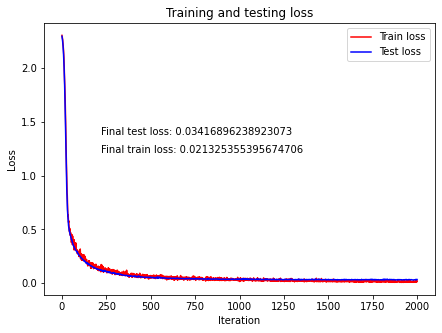

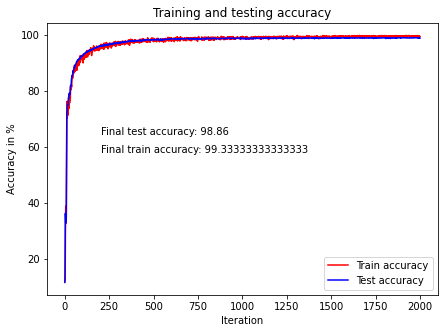

In [541]:
plt.figure(1, figsize = (7, 5)) 
loss_tra, = plt.plot(loss_train, 'r') 
loss_tes, = plt.plot(loss_test, 'b') 
plt.title("Training and testing loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend([loss_tra, loss_tes], ['Train loss', 'Test loss'])
plt.annotate("Final train loss: %s" % (loss_train[-1]) ,xycoords = 'figure fraction', xy = (0.2,0.5))
plt.annotate("Final test loss: %s" % (loss_test[-1]), xycoords = 'figure fraction', xy = (0.2,0.55))
print("Final training loss: %s." % loss_train[-1]) 
print("Final testing loss: %s." % loss_test[-1]) 
plt.savefig("train_debug", dpi = 500) 

plt.figure(2, figsize = (7, 5)) 
acc_tra, = plt.plot(acc_train, 'r') 
acc_tes, = plt.plot(acc_test, 'b') 
plt.title("Training and testing accuracy") 
plt.xlabel("Iteration") 
plt.ylabel("Accuracy in %") 
plt.legend([acc_tra, acc_tes], ['Train accuracy', 'Test accuracy'])
plt.annotate("Final train accuracy: %s" % (acc_train[-1]) ,xycoords = 'figure fraction', xy = (0.2,0.5))
plt.annotate("Final test accuracy: %s" % (acc_test[-1]), xycoords = 'figure fraction', xy = (0.2,0.55))
print()
print("Final training accuracy: %s%%." % acc_train[-1])
print("Final testing accuracy: %s%%." % acc_test[-1])
plt.savefig("test_debug", dpi = 500) 